In [22]:
def mul(*v):
    ret=1
    for x in v:
        ret*=x
    return ret

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
#from torchvision.utils import save_image
#from tqdm import tqdm

#from torchsummary import summary
from matplotlib import pyplot as plt
import numpy as np
#import cv2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [24]:
SEED=42

In [25]:
l = torchvision.datasets.MNIST(root='./mnist_data/', train = True, download = True, transform = transforms.ToTensor())
t = torchvision.datasets.MNIST(root='./mnist_data/', train = False, download = True, transform = transforms.ToTensor())

In [26]:
l.data.shape,l.targets.shape

(torch.Size([60000, 28, 28]), torch.Size([60000]))

In [27]:
l.data[0].shape,l.targets[0]

(torch.Size([28, 28]), tensor(5))

In [28]:
img_shape=tuple(l.data[0].shape)
img_dim=mul(*img_shape)
img_shape,img_dim

((28, 28), 784)

In [29]:
x_l=l.data.numpy()
y_l=l.targets.numpy()
x_t=t.data.numpy()
y_t=t.targets.numpy()

In [30]:
IMG_DTYPE=np.float32

#training set
yl=y_l #get selected imgs
xl=x_l.astype(IMG_DTYPE)/255 #color 0~255

#testing set
T_SIZE=1000
yt=y_t[:T_SIZE]
xt=x_t[:T_SIZE].astype(IMG_DTYPE)/255

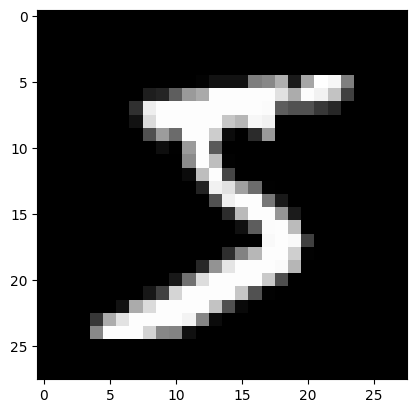

In [31]:
plt.imshow(xl[0], cmap='gray') 

In [32]:
L_BATCH_SIZE=64
T_BATCH_SIZE=100


#create dataloaders
ld=torch.utils.data.DataLoader(
    list(zip(xl,yl)),shuffle=True,batch_size=L_BATCH_SIZE
)
td=torch.utils.data.DataLoader(
    list(zip(xt,yt)),shuffle=True,batch_size=T_BATCH_SIZE
)

In [33]:
Z_DIM=16
MID_DIM=256
num_tags=len(set(yl))

class VAE(nn.Module):
    def __init__(self,z_dim=Z_DIM,mid_dim=MID_DIM,num_tags=num_tags):
        super().__init__()
        self.fc1 = nn.Linear(img_dim, mid_dim)
        
        self.fc21 = nn.Linear(mid_dim,z_dim) #mu (mean)
        self.fc22 = nn.Linear(mid_dim, z_dim) #sigma (std)


        self.fc3 = nn.Linear(z_dim, mid_dim)
        self.fc4 = nn.Linear(mid_dim,img_dim)

        self.mu_shift = nn.Embedding(num_tags, z_dim)
        self.std_shift = nn.Embedding(num_tags, z_dim)
        
    def encode(self,x):
        x=torch.relu(self.fc1(x))
        return self.fc21(x),self.fc22(x)

    def decode(self,z):
        return F.sigmoid(
            self.fc4(
                torch.relu(
                    self.fc3(
                        z
                    )
                )
            )
        )
    
    def gen(self,tag,e=0):
        return self.decode(
            self.mu_shift(tag)+e*(torch.abs(self.std_shift(tag))+1)
        )



    def forward(self, x, tag):
        mu, log_std = self.encode(
            x.view(-1, img_dim)
        )
        std=torch.exp(log_std*0.5)
        z=self.mu_shift(tag)+mu+(torch.abs(self.std_shift(tag))+std)*torch.randn_like(std)
        return self.decode(z),mu,std,log_std

In [34]:
def loss_fn(x, y, mu, std, log_std): 
    '''BCE + KLD'''
    return F.binary_cross_entropy(y, x.view(-1, img_dim), reduction='sum') + \
        torch.sum(1 + log_std - mu**2 - std**2)* -0.5*2

In [35]:
torch.manual_seed(SEED)
model=VAE().to(device)
op=torch.optim.Adam(
    model.parameters(),
    lr=0.002
)

In [36]:
I=torch.eye(Z_DIM).to(device)*99

In [37]:
def l_step(
    model: torch.nn.Module,
    dl: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    op: torch.optim.Optimizer,
    epochs:int=50
):
    # Put model in train mode
    model.train()

    for epoch in range(epochs):
        epoch_loss = 0
        for batch_idx,(x,tag) in enumerate(dl):
            
            x,tag=x.to(device),tag.to(device)
            #print(type(tag))

            # 1. Forward pass
            y,mu,std,log_std = model(x,tag)

            # 2. Caculate the loss
            loss=loss_fn(x,y,mu,std,log_std)

            # 3. Optimizer zero grad
            op.zero_grad()

            # 4. Loss backward
            loss.backward()

            # 5. Optimizer step
            op.step()

            epoch_loss+=loss.item()
        
        if epoch%10==0:
            print(epoch_loss)
            
    model.eval()


In [38]:
torch.manual_seed(SEED)
l_step(
    model,
    ld,
    loss_fn,
    op,
    50
)

9768958.096191406
7390391.971191406
7265125.813232422
7208372.702636719
7175844.1767578125


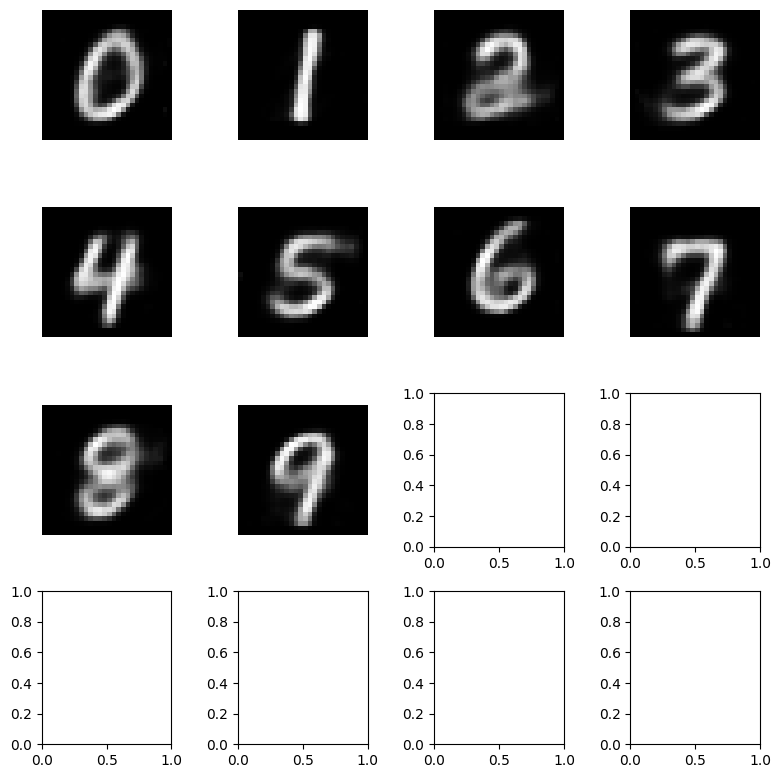

In [39]:
"""
sample at mu (stuff after 9 should not carry any meaning)
"""
# Create a 3x3 grid of subplots
fig, axes = plt.subplots(4, 4, figsize=(8, 8))

# Loop through the axes and images
for i,ax in zip(range(num_tags),axes.ravel()):
    ax.imshow(model.gen(torch.Tensor([i]).long().to(device)).cpu().view(*img_shape).detach().numpy(), cmap='gray')  # Display each image
    ax.axis('off')  # Hide axes for better visualization

plt.tight_layout()
plt.show()

In [40]:
for i in range(num_tags):
    for j in range(num_tags):
        print(
            torch.sum(
                (
                    model.mu_shift(torch.Tensor([i]).long().to(device)).cpu().detach() - \
                    model.mu_shift(torch.Tensor([j]).long().to(device)).cpu().detach()
                )**2
            )
    )

tensor(0.)
tensor(207.9590)
tensor(67.5395)
tensor(193.5771)
tensor(284.3092)
tensor(166.0616)
tensor(106.3890)
tensor(117.8682)
tensor(104.1679)
tensor(172.5707)
tensor(207.9590)
tensor(0.)
tensor(267.1421)
tensor(224.4188)
tensor(206.6625)
tensor(197.8783)
tensor(147.1810)
tensor(237.5551)
tensor(186.5108)
tensor(129.9837)
tensor(67.5395)
tensor(267.1421)
tensor(0.)
tensor(113.7846)
tensor(364.8806)
tensor(208.8241)
tensor(224.7654)
tensor(162.3877)
tensor(140.7972)
tensor(220.4256)
tensor(193.5771)
tensor(224.4188)
tensor(113.7846)
tensor(0.)
tensor(281.8822)
tensor(103.1245)
tensor(191.0389)
tensor(249.8073)
tensor(175.2771)
tensor(163.5869)
tensor(284.3092)
tensor(206.6625)
tensor(364.8806)
tensor(281.8822)
tensor(0.)
tensor(265.2490)
tensor(152.5404)
tensor(160.5958)
tensor(255.3610)
tensor(65.9000)
tensor(166.0616)
tensor(197.8783)
tensor(208.8241)
tensor(103.1245)
tensor(265.2490)
tensor(0.)
tensor(108.5557)
tensor(257.7264)
tensor(182.2856)
tensor(151.5892)
tensor(106.3890)
te

In [41]:
for i in range(num_tags):
    for j in range(num_tags):
        print(
            torch.sum(
                (
                    model.std_shift(torch.Tensor([i]).long().to(device)).cpu().detach() - \
                    model.std_shift(torch.Tensor([j]).long().to(device)).cpu().detach()
                )**2
            )
    )

tensor(0.)
tensor(5.5804e-05)
tensor(2.5493e-05)
tensor(2.5856e-05)
tensor(2.8954e-05)
tensor(3.0531e-05)
tensor(0.0001)
tensor(4.8770e-05)
tensor(4.7483e-05)
tensor(2.6867e-05)
tensor(5.5804e-05)
tensor(0.)
tensor(4.4214e-05)
tensor(8.0216e-05)
tensor(9.4368e-05)
tensor(0.0001)
tensor(0.0002)
tensor(0.0001)
tensor(0.0001)
tensor(8.9060e-05)
tensor(2.5493e-05)
tensor(4.4214e-05)
tensor(0.)
tensor(2.1152e-05)
tensor(2.5503e-05)
tensor(3.6519e-05)
tensor(7.2084e-05)
tensor(3.0076e-05)
tensor(3.7101e-05)
tensor(4.3030e-05)
tensor(2.5856e-05)
tensor(8.0216e-05)
tensor(2.1152e-05)
tensor(0.)
tensor(3.0291e-05)
tensor(2.7692e-05)
tensor(8.7444e-05)
tensor(3.4494e-05)
tensor(5.8184e-05)
tensor(4.5052e-05)
tensor(2.8954e-05)
tensor(9.4368e-05)
tensor(2.5503e-05)
tensor(3.0291e-05)
tensor(0.)
tensor(3.2087e-05)
tensor(7.7823e-05)
tensor(1.7027e-05)
tensor(3.9639e-05)
tensor(3.2913e-05)
tensor(3.0531e-05)
tensor(0.0001)
tensor(3.6519e-05)
tensor(2.7692e-05)
tensor(3.2087e-05)
tensor(0.)
tensor(9

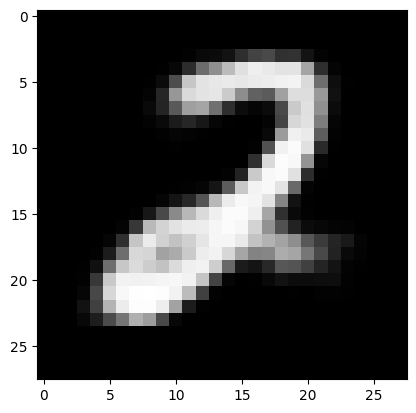

In [46]:
plt.imshow(model.gen(
    torch.Tensor([2]).long().to(device),torch.normal(0,1,size=(1,Z_DIM)).to(device)
).cpu().view(*img_shape).detach().numpy(), cmap='gray') 